# Moving Average, Augmented Dicky Fuller Test, GARCH

In this Notebook, we will focus on: 1) Moving average model; 2) ADFT; 3) GARCH

## Moving Average (MA)

In this part, we use AR model to predict Apple's stock price. Again, the data is from Apple.Inc (one year: from 28/Dec/2020 to 27/Dec/2021). In order to help you gain the insights of AR model, instead of using exsiting Python Statsmodels library (https://www.statsmodels.org/dev/generated/statsmodels.tsa.ar_model.AutoReg.html), I tend to show an example to implement AR from scratch. Addtionally, you can use this Statsmodels library to test performance by yourself. 

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
pd.options.mode.chained_assignment = None  # default='warn'

In [31]:
df=pd.read_csv('AAPL.csv', parse_dates=['Date'], index_col=['Date'], dayfirst=True)
df.columns=['Open']
df

,Open
Date,
2020-12-28,133.990005
2020-12-29,138.050003
2020-12-30,135.580002
2020-12-31,134.080002
2021-01-04,133.520004
...,...
2021-12-20,168.279999
2021-12-21,171.559998
2021-12-22,173.039993


In [32]:
def AR(p,df):
  df_temp = df

  #Generating the lagged p terms
  for i in range(1,p+1):
    df_temp['Shifted_values_%d' % i ] = df_temp['Open'].shift(i)

  train_size = (int)(0.8 * df_temp.shape[0])

  #Breaking data set into test and training
  df_train = pd.DataFrame(df_temp[0:train_size])
  df_test = pd.DataFrame(df_temp[train_size:df.shape[0]])

  df_train_2 = df_train.dropna()
  #X contains the lagged values ,hence we skip the first column
  X_train = df_train_2.iloc[:,1:].values.reshape(-1,p)
  #Y contains the value,it is the first column
  y_train = df_train_2.iloc[:,0].values.reshape(-1,1)

  #Running linear regression to generate the coefficents of lagged terms
  from sklearn.linear_model import LinearRegression
  lr = LinearRegression()
  lr.fit(X_train,y_train)

  theta  = lr.coef_.T
  intercept = lr.intercept_
  df_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
  df_train_2[['Value','Predicted_Values']].plot()

  X_test = df_test.iloc[:,1:].values.reshape(-1,p)
  df_test['Predicted_Values'] = X_test.dot(lr.coef_.T) + lr.intercept_
  df_test[['Value','Predicted_Values']].plot()

  RMSE = np.sqrt(mean_squared_error(df_test['Open'], df_test['Predicted_Values']))

  print("The RMSE is :", RMSE,", Value of p : ",p)
  return [df_train_2,df_test,theta,intercept,RMSE]

From the figure of PACF, we can use 2 as the lag number.

In [33]:
lag_num = 2

#Step 2 : Fitting AR Model

We calculate the error on the test-set for each p, and pick the best one.

In [34]:
[df_train,df_test,theta,intercept,RMSE] = AR(2,pd.DataFrame(df.Open))

KeyError: "['Value'] not in index"

In [ ]:
df_c = pd.concat([df_train,df_test])
res = pd.DataFrame()
res['Residuals'] = df_c.Open - df_c.Predicted_Values

In [ ]:
res['Residuals']

Date
2020-12-30   -2.540053
2020-12-31   -1.444260
2021-01-04   -0.564306
2021-01-05   -4.672706
2021-01-06   -1.202767
                ...   
2021-12-20   -0.643016
2021-12-21    4.037560
2021-12-22    2.173941
2021-12-23    3.586509
2021-12-27    2.036987
Name: Residuals, Length: 250, dtype: float64

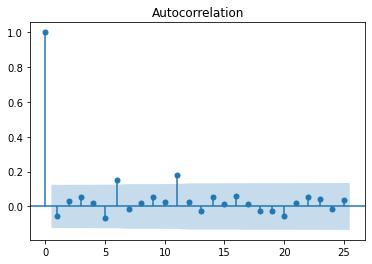

In [ ]:
ACF = plot_acf(res['Residuals'],lags=25)

## Function to carry out Moving Average process

In [ ]:
def MA(q,res):

  for i in range(1,q+1):
    res['Shifted_values_%d' % i ] = res['Residuals'].shift(i)

  train_size = (int)(0.8 * res.shape[0])

  res_train = pd.DataFrame(res[0:train_size])
  res_test = pd.DataFrame(res[train_size:res.shape[0]])

  res_train_2 = res_train.dropna()
  X_train = res_train_2.iloc[:,1:].values.reshape(-1,q)
  y_train = res_train_2.iloc[:,0].values.reshape(-1,1)

  from sklearn.linear_model import LinearRegression
  lr = LinearRegression()
  lr.fit(X_train,y_train)

  theta  = lr.coef_.T
  intercept = lr.intercept_
  res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
  # res_train_2[['Residuals','Predicted_Values']].plot()

  X_test = res_test.iloc[:,1:].values.reshape(-1,q)
  res_test['Predicted_Values'] = X_test.dot(lr.coef_.T) + lr.intercept_
  # res_test[['Residuals','Predicted_Values']].plot()

  from sklearn.metrics import mean_squared_error
  RMSE = np.sqrt(mean_squared_error(res_test['Residuals'], res_test['Predicted_Values']))

  print("The RMSE is :", RMSE,", Value of q : ",q)
  return [res_train_2,res_test,theta,intercept,RMSE]

## Choosing best order (q value) for Moving Average process

In [ ]:
best_RMSE=100000000000
best_q = -1

for i in range(1,13):
  [res_train,res_test,theta,intercept,RMSE] = MA(i,pd.DataFrame(res.Residuals))
  if(RMSE<best_RMSE):
    best_RMSE = RMSE
    best_q = i
  
print(best_q)

The RMSE is : 3.2541985735342434 , Value of q :  1
The RMSE is : 3.281323177072352 , Value of q :  2
The RMSE is : 3.2904313465395383 , Value of q :  3
The RMSE is : 3.3002276691781947 , Value of q :  4
The RMSE is : 3.313072548521662 , Value of q :  5
The RMSE is : 3.2575624939001466 , Value of q :  6
The RMSE is : 3.2754950579853643 , Value of q :  7
The RMSE is : 3.356476436893415 , Value of q :  8
The RMSE is : 3.371112151659533 , Value of q :  9
The RMSE is : 3.3686741089073755 , Value of q :  10
The RMSE is : 3.2917687023999966 , Value of q :  11
The RMSE is : 3.3132644974148415 , Value of q :  12
1


In [ ]:
[res_train,res_test,theta,intercept,RMSE] = MA(best_q,pd.DataFrame(res.Residuals))
print(theta)
print(intercept)

The RMSE is : 3.2541985735342434 , Value of q :  1
[[0.01152856]]
[0.0179795]


3.2541985735342434


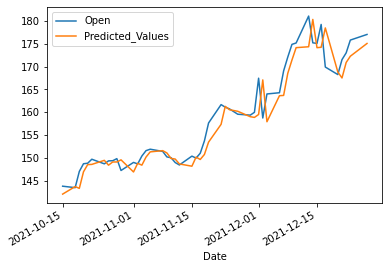

In [ ]:
df_test = df_test.iloc[1:]
df_test.Predicted_Values = df_test.Predicted_Values + res_test.Predicted_Values
df_test[['Open','Predicted_Values']].plot()
RMSE = np.sqrt(mean_squared_error(df_test['Open'], df_test['Predicted_Values']))
print(RMSE)

## Augmented Dickey–Fuller test 

In [ ]:
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','Number of Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary \n")

In [ ]:
df_ADF = pd.read_csv('AAPL.csv', header=0, infer_datetime_format=True, parse_dates=[0], index_col=[0])
adf_check(df_ADF)

Augmented Dickey-Fuller Test:
ADF Test Statistic : -0.002954911878457559
p-value : 0.9582870336467576
Number of Lags Used : 0
Number of Observations Used : 251
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 



In [ ]:
df_ADF['Open'] = df_ADF['Open'].diff().diff()
df_ADF = df.drop(df.index[[0,1]])
df_ADF
adf_check(df)

Augmented Dickey-Fuller Test:
ADF Test Statistic : -0.002954911878457559
p-value : 0.9582870336467576
Number of Lags Used : 0
Number of Observations Used : 251
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 



# GARCH for Volatility Prediction

## Read Data

In [ ]:
import pandas_datareader.data as web
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np

# Case study: Apple stock price

In [ ]:
# set the start date and the end date you would like to study
# start = datetime("2010-01-01")
# end = datetime("2020-06-10")
start = "2010-01-01"
end = "2020-06-10"

In [ ]:
# extract data from various Internet sources into a pandas DataFrame.
# Not limited with finance data from Yahoo, it provides other popular data sources (e.g., world bank, Naver).
# See details: https://pandas-datareader.readthedocs.io/en/latest/remote_data.html
aapl = web.DataReader('AAPL', 'yahoo', start=start, end=end)

In [ ]:
# calculate volatility of returns by the function pct_change()
# For more details about why view percentage change as volatility: https://finance.zacks.com/price-change-vs-volatility-7592.html
returns = 100 * aapl.Close.pct_change().dropna()

Text(0.5, 1.0, 'AAPL Returns')

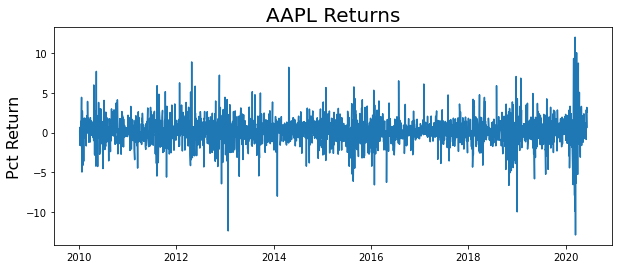

In [ ]:
# visualise PCT return that is the percentage change from the immediately previous row by default
plt.figure(figsize=(10,4))
plt.plot(returns)
plt.ylabel('Pct Return', fontsize=16)
plt.title('AAPL Returns', fontsize=20)

## PACF

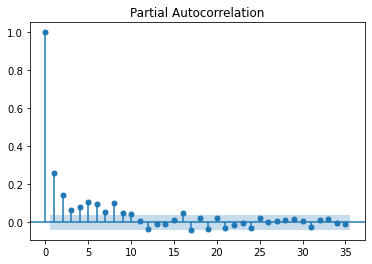

In [ ]:
# calculate the PACF with the variance of return as an input
plot_pacf(returns**2, method='ywm')
plt.show()

## Fit GARCH(3,3)

In [ ]:
# A GARCH model subsumes ARCH models, where a GARCH(0, q) is equivalent to an ARCH(q) model.
model = arch_model(returns, p=3, q=3)

In [ ]:
model_fit = model.fit()

Iteration:      1,   Func. Count:     10,   Neg. LLF: 15446.467306460918
Iteration:      2,   Func. Count:     23,   Neg. LLF: 4261980878.2285337
Iteration:      3,   Func. Count:     34,   Neg. LLF: 5964.864036484298
Iteration:      4,   Func. Count:     44,   Neg. LLF: 5135.076623060451
Iteration:      5,   Func. Count:     55,   Neg. LLF: 4998.763463076342
Iteration:      6,   Func. Count:     65,   Neg. LLF: 5045.593908554274
Iteration:      7,   Func. Count:     76,   Neg. LLF: 4969.425180512532
Iteration:      8,   Func. Count:     86,   Neg. LLF: 4955.545073731328
Iteration:      9,   Func. Count:     96,   Neg. LLF: 4958.1362356550435
Iteration:     10,   Func. Count:    106,   Neg. LLF: 4975.462255637902
Iteration:     11,   Func. Count:    117,   Neg. LLF: 4953.705120173426
Iteration:     12,   Func. Count:    127,   Neg. LLF: 4953.040244469283
Iteration:     13,   Func. Count:    136,   Neg. LLF: 4953.028074437223
Iteration:     14,   Func. Count:    145,   Neg. LLF: 4953.02

In [ ]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4953.03
Distribution:                  Normal   AIC:                           9922.05
Method:            Maximum Likelihood   BIC:                           9969.04
                                        No. Observations:                 2626
Date:                Thu, Mar 10 2022   Df Residuals:                     2625
Time:                        16:32:17   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.1830  3.256e-02      5.623  1.880e-08 [  0.119,  0.247]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.4266      0.207      2.065  3.897e-02    [2.161e-02,  0.832]
alpha[1]       0.1616  4.204e-02      3.844  1.210e-04    [7.921e-02,  0.244]
alpha[2]       0.0636  9.487e-02      0.671      0.502      [ -0.122,  0.250]
alpha[3]       0.0339  2.940e-02      1.152      0.249 [-2.376e-02,9.149e-02]
beta[1]    7.4285e-16      0.533  1.393e-15      1.000      [ -1.045,  1.045]
beta[2]        0.5384      0.154      3.504  4.576e-04      [  0.237,  0.840]
beta[3]        0.0659      0.323      0.204      0.838      [ -0.566,  0.698]
=============================================================================

Covariance estimator: robust
"""

# How to use the model

In [ ]:
train = returns
model = arch_model(train, p=2, q=2)
model_fit = model.fit(disp='off')

In [ ]:
from arch.__future__ import reindexing
pred = model_fit.forecast(horizon=7)
future_dates = [returns.index[-1] + timedelta(days=i) for i in range(1,8)]
pred = pd.Series(np.sqrt(pred.variance.values[-1,:]), index=future_dates)

Text(0.5, 1.0, 'Volatility Prediction - Next 7 Days')

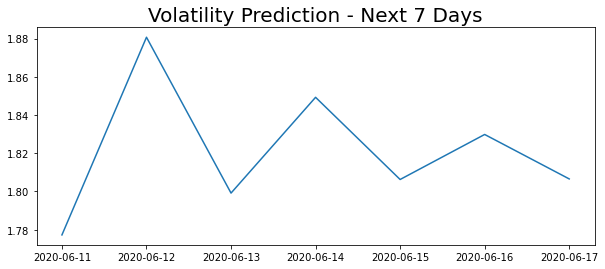

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(pred)
plt.title('Volatility Prediction - Next 7 Days', fontsize=20)